In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Epoch 1/10
2/2 [==============================] - 4s 1s/step - loss: 50.8531 - accuracy: 0.3725 - val_loss: 111.3532 - val_accuracy: 0.8462
Epoch 2/10
2/2 [==============================] - 1s 496ms/step - loss: 88.7639 - accuracy: 0.8824 - val_loss: 54.5942 - val_accuracy: 0.8462
Epoch 3/10
2/2 [==============================] - 1s 546ms/step - loss: 40.9412 - accuracy: 0.8824 - val_loss: 7.8805 - val_accuracy: 0.8462
Epoch 4/10
2/2 [==============================] - 1s 544ms/step - loss: 22.7504 - accuracy: 0.5882 - val_loss: 0.2609 - val_accuracy: 0.8462
Epoch 5/10
2/2 [==============================] - 1s 571ms/step - loss: 3.3172 - accuracy: 0.9216 - val_loss: 9.9873 - val_accuracy: 0.8462
Epoch 6/10
2/2 [==============================] - 1s 459ms/step - loss: 8.7449 - accuracy: 0.8824 - val_loss: 10.3614 - val_accuracy: 0.8462
Epoch 7/10
2/2 [==============================] - 1s 453ms/step - loss: 7.8290 - accuracy: 0.8824 - val_loss: 4.8565 - val_accuracy: 0.8462
Epoch 8/10
2/2 

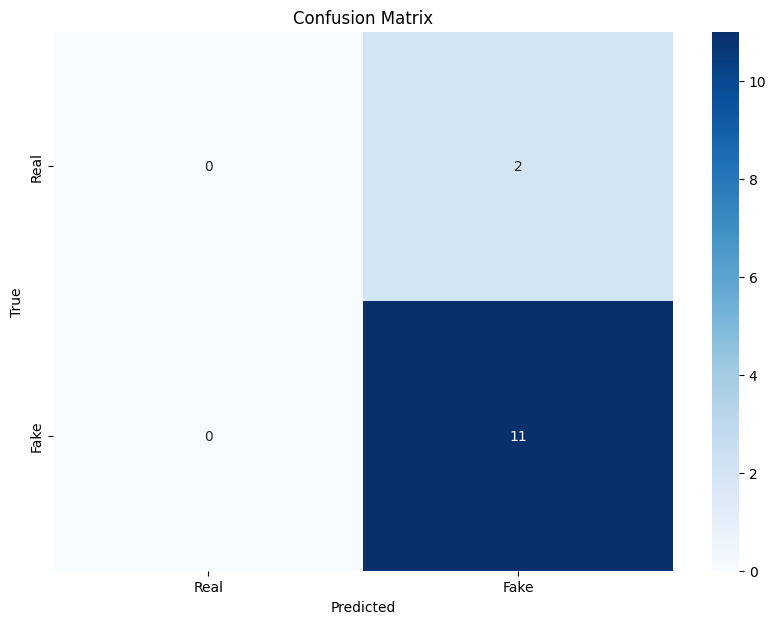

In [6]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Define paths
real_dataset_path = '/content/drive/MyDrive/dataset/TeamDeepwave/dataset/KaggleDataset/real'
fake_dataset_path = '/content/drive/MyDrive/dataset/TeamDeepwave/dataset/KaggleDataset/fake'

# Load audio files and extract features
def load_and_extract_features(file_path, max_pad_len=128):
    y, sr = librosa.load(file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    if mel_spectrogram_db.shape[1] > max_pad_len:
        mel_spectrogram_db = mel_spectrogram_db[:, :max_pad_len]
    else:
        pad_width = max_pad_len - mel_spectrogram_db.shape[1]
        mel_spectrogram_db = np.pad(mel_spectrogram_db, pad_width=((0, 0), (0, pad_width)), mode='constant')

    return mel_spectrogram_db

# Get file paths and labels
real_files = [os.path.join(real_dataset_path, f) for f in os.listdir(real_dataset_path) if f.endswith('.wav')]
fake_files = [os.path.join(fake_dataset_path, f) for f in os.listdir(fake_dataset_path) if f.endswith('.wav')]
real_labels = [0] * len(real_files)  # Label 0 for real
fake_labels = [1] * len(fake_files)  # Label 1 for fake

# Combine datasets
file_paths = real_files + fake_files
labels = real_labels + fake_labels

# Split the data
X_train_paths, X_test_paths, y_train, y_test = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

# Prepare the data
def prepare_data(file_paths):
    data = []
    for file_path in file_paths:
        features = load_and_extract_features(file_path)
        data.append(features)
    return np.array(data)

X_train = prepare_data(X_train_paths)
X_test = prepare_data(X_test_paths)

# Convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape the data for the Conv2D layer
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Confusion Matrix:\n {conf_matrix}")

# Visualize confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()